In [1]:
import xarray as xr
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [2]:
#
# refer to notes 01/26/2021 for the version information
# Version 5 split the data using 2012-2014 for training
# this is the 0:3671 images
#

In [3]:
#
# load 0 min offset 3D refl data
#
refl_data_main_path = '/glade/work/hardt/ds612'
refl_ds = xr.open_dataset(os.path.join(refl_data_main_path, "model2_2012-2015_00minuteAfterHour_3D_refl.nc"))
refl = refl_ds.REFL_10CM[:3671,:,:,:].values

In [4]:
#
# scaled 3D data
#
refl_scaled = (refl - np.amin(refl)) / (np.percentile(refl, 99.99) - np.amin(refl))

In [5]:
print(refl.shape)
print(refl_scaled.shape)

(3671, 10, 256, 256)
(3671, 10, 256, 256)


In [6]:
#
# What happens in train-unet_model_v6p0.py
#
feature = np.copy(refl_scaled)
feature = np.moveaxis(feature, 1, 3)

In [7]:
#
# lowest level of Refl data
#
#feature2D = refl[:,0,:,:]
#
# composite refl data
#
feature2D = feature[:,:,:,:].max(axis=3)
feature2D = feature2D[:,:,:,np.newaxis]

In [8]:
print(feature.shape)
print(feature2D.shape)
print(np.amin(feature2D))

(3671, 256, 256, 10)
(3671, 256, 256, 1)
0.0


In [9]:
#
# flatten data to be used in histogram
#
refl_f = refl.flatten()

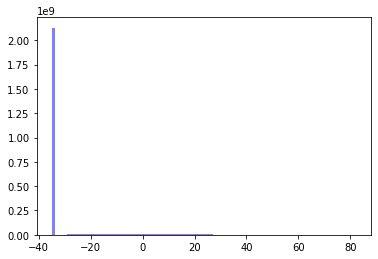

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# Colours for different percentiles
perc_25_colour = 'gold'
perc_50_colour = 'mediumaquamarine'
perc_75_colour = 'deepskyblue'
perc_95_colour = 'peachpuff'

# Plot the Histogram from the random data
#fig, ax = plt.subplots(figsize=(8,8))

#n, bins, patches = plt.hist(x, 50, normed=1, facecolor='green', alpha=0.75)
num_bins = 100
n, bins, patches = plt.hist(refl_f, num_bins, facecolor='blue', alpha=0.5)
#n, bins, patches = plt.hist(ft_scaled[ft_scaled<=np.percentile(ft_scaled,99.0)], num_bins, facecolor='blue', alpha=0.5)
#_ = ax.hist(ft,bins=1000)

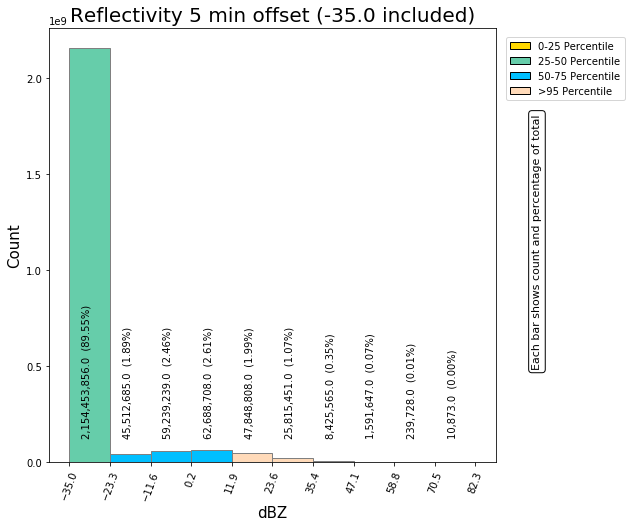

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# Colours for different percentiles
perc_25_colour = 'gold'
perc_50_colour = 'mediumaquamarine'
perc_75_colour = 'deepskyblue'
perc_95_colour = 'peachpuff'

# Plot the Histogram from the random data
fig, ax = plt.subplots(figsize=(8,8))

'''
counts  = numpy.ndarray of count of data ponts for each bin/column in the histogram
bins    = numpy.ndarray of bin edge/range values
patches = a list of Patch objects.
        each Patch object contains a Rectnagle object. 
        e.g. Rectangle(xy=(-2.51953, 0), width=0.501013, height=3, angle=0)
'''
counts, bins, patches = ax.hist(refl_f, facecolor=perc_50_colour, edgecolor='gray')


# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins.round(2))
plt.xticks(rotation=70)

# Set the graph title and axes titles
plt.title('Reflectivity 5 min offset (-35.0 included)', fontsize=20)
#plt.title('W', fontsize=20)

plt.ylabel('Count', fontsize=15)
plt.xlabel('dBZ', fontsize=15)

# Change the colors of bars at the edges
twentyfifth, seventyfifth, ninetyfifth = np.percentile(refl_f, [25, 75, 95])
for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
    if rightside < twentyfifth:
        patch.set_facecolor(perc_25_colour)
    elif leftside > ninetyfifth:
        patch.set_facecolor(perc_95_colour)
    elif leftside > seventyfifth:
        patch.set_facecolor(perc_75_colour)
        
# Calculate bar centre to display the count of data points and %
bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
bin_y_centers = ax.get_yticks()[1] * 0.25

# Display the the count of data points and % for each bar in histogram
for i in range(len(bins)-1):
    bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
    plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

# Annotation for bar values
ax.annotate('Each bar shows count and percentage of total',
            xy=(.85,.30), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='bottom',
            fontsize=11, bbox=dict(boxstyle="round", fc="white"),
            rotation=90)

#create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [perc_25_colour, perc_50_colour, perc_75_colour, perc_95_colour]]
labels= ["0-25 Percentile","25-50 Percentile", "50-75 Percentile", ">95 Percentile"]
plt.legend(handles, labels, bbox_to_anchor=(0.5, 0., 0.80, 0.99))

# Display the graph
plt.show()

In [12]:
#
# load the 3D W data
#
W_data_main_path = '/glade/work/hardt/ds612'
W_ds = xr.open_dataset(os.path.join(W_data_main_path, "model2_2012-2015_3D_W.nc"))
print('Loading W data.')
W = W_ds.W[:3671,:,:,:].values

Loading W data.


In [13]:
print(W.shape)

(3671, 51, 256, 256)


In [14]:
#
# composite W to creat the label data
#
label = W[:,:,:,:].max(axis=1)
label = label[:,:,:,np.newaxis]

In [15]:
#
# scale the data
#
label_scaled = (label - np.amin(label)) / (np.percentile(label, 99.0) - np.amin(label))
print(label_scaled.shape)
#
# set values back to -99.0
#
label_scaled[feature2D<0.001] = -99.0
#
label_thresh = label_scaled[label_scaled!=-99.0]
print(label_thresh.shape)

(3671, 256, 256, 1)
(66409398,)


In [16]:
W_flat = W.flatten()
print(W_flat.shape)

(12269715456,)


In [17]:
#
# flatten the W data for plotting in histogram
#
flat = label_thresh.flatten()
#flat = flat[flat!=-99.0]
print(flat.shape)

(66409398,)


In [18]:
print(np.amin(flat))
#
print()
#
print(np.amax(flat))

0.0

35.049896


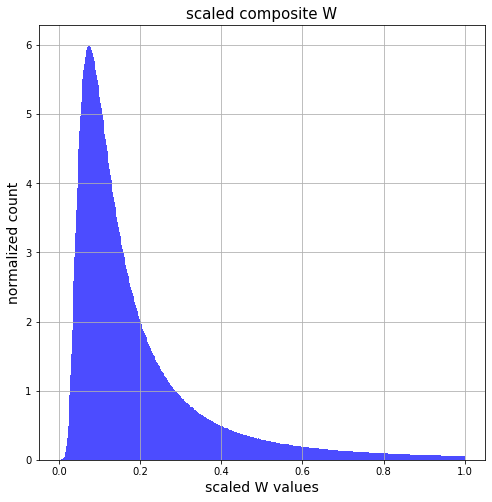

In [21]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# Colours for different percentiles
perc_25_colour = 'gold'
perc_50_colour = 'mediumaquamarine'
perc_75_colour = 'deepskyblue'
perc_95_colour = 'peachpuff'

# Plot the Histogram from the random data
#fig, ax = plt.subplots(figsize=(8,8))

#n, bins, patches = plt.hist(x, 50, normed=1, facecolor='green', alpha=0.75)
num_bins = 500

plt.subplots(figsize=(8,8))

#n, bins, patches = plt.hist(W_flat, num_bins, range=[-0.5, 0.5], density=True, facecolor='blue', alpha=0.7)
n, bins, patches = plt.hist(flat, num_bins, range=[0, 1.0], density=True, facecolor='blue', alpha=0.7)
#
#plt.title('W', fontsize=15)
#plt.xlabel('W values', fontsize=14)
#plt.ylabel('normalized count', fontsize=14)
#
plt.title('scaled composite W', fontsize=15)
plt.xlabel('scaled W values', fontsize=14)
plt.ylabel('normalized count', fontsize=14)
#
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

#n, bins, patches = plt.hist(ft_scaled[ft_scaled<=np.percentile(ft_scaled,99.0)], num_bins, facecolor='blue', alpha=0.5)
#_ = ax.hist(ft,bins=1000)

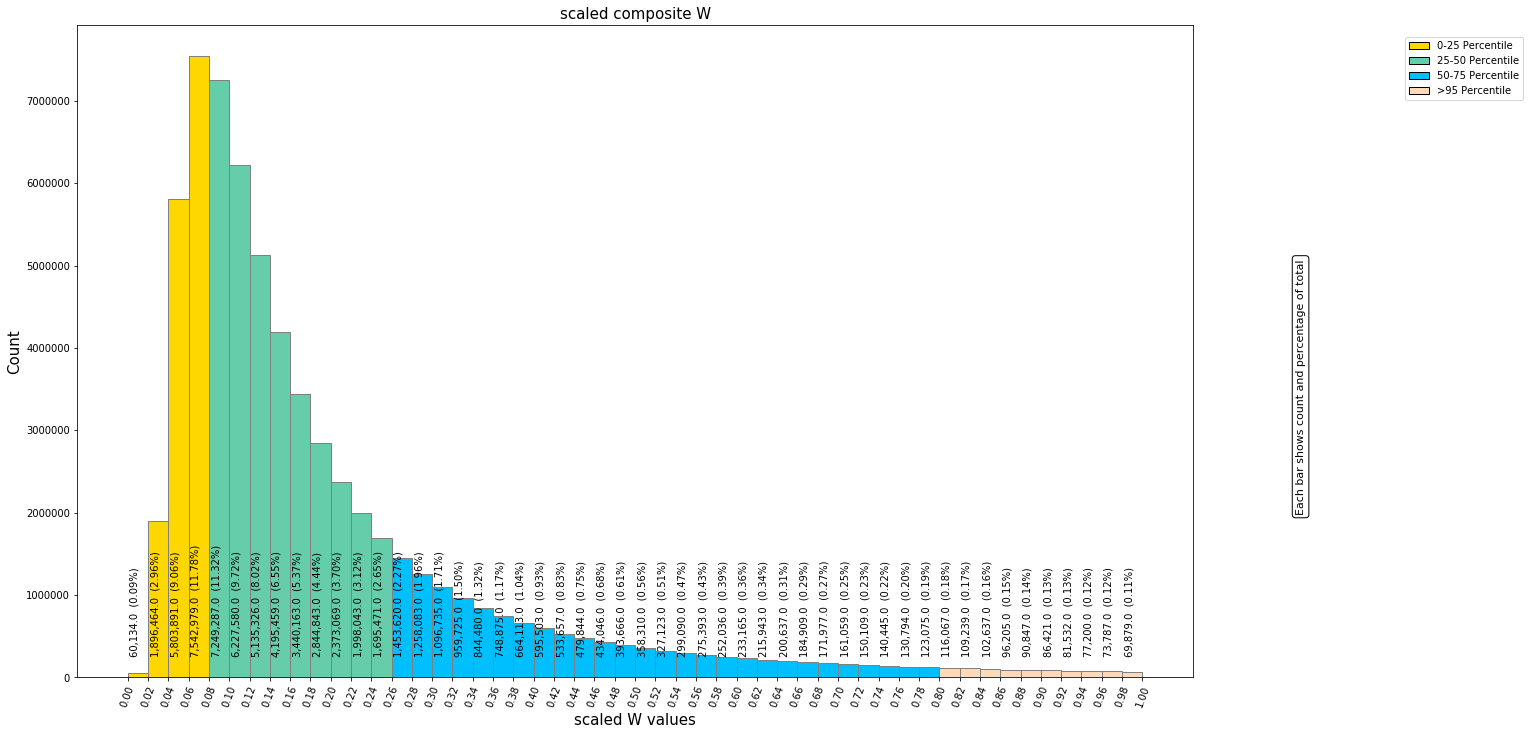

In [22]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# Colours for different percentiles
perc_25_colour = 'gold'
perc_50_colour = 'mediumaquamarine'
perc_75_colour = 'deepskyblue'
perc_95_colour = 'peachpuff'

# Plot the Histogram from the random data
#fig, ax = plt.subplots(figsize=(8,8))
fig, ax = plt.subplots(figsize=(20,12))

'''
counts  = numpy.ndarray of count of data ponts for each bin/column in the histogram
bins    = numpy.ndarray of bin edge/range values
patches = a list of Patch objects.
        each Patch object contains a Rectnagle object. 
        e.g. Rectangle(xy=(-2.51953, 0), width=0.501013, height=3, angle=0)
'''
num_bins = 50
#counts, bins, patches = ax.hist(W_flat, num_bins, range=[-0.5, 0.5], facecolor=perc_50_colour, edgecolor='gray')
counts, bins, patches = ax.hist(flat, num_bins, range=[0, 1.0], facecolor=perc_50_colour, edgecolor='gray')
#counts, bins, patches = ax.hist(flat, facecolor=perc_50_colour, edgecolor='gray')
#print(bins)

# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins.round(2))
plt.xticks(rotation=70)

# Set the graph title and axes titles
plt.title('scaled composite W', fontsize=15)
#
plt.ylabel('Count', fontsize=15)
#
#plt.xlabel('scaled W (min, precentile 99.9)', fontsize=15)
#plt.xlabel('W values', fontsize=15)
plt.xlabel('scaled W values', fontsize=15)
#plt.xlabel('W values (where ref comp != -35.0, scaled min and max) ', fontsize=15)
#
# Change the colors of bars at the edges
#twentyfifth, seventyfifth, ninetyfifth = np.percentile(W_flat, [25, 75, 95])
twentyfifth, seventyfifth, ninetyfifth = np.percentile(flat, [25, 75, 95])
for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
    if rightside < twentyfifth:
        patch.set_facecolor(perc_25_colour)
    elif leftside > ninetyfifth:
        patch.set_facecolor(perc_95_colour)
    elif leftside > seventyfifth:
        patch.set_facecolor(perc_75_colour)
        
# Calculate bar centre to display the count of data points and %
bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
bin_y_centers = ax.get_yticks()[1] * 0.25

# Display the the count of data points and % for each bar in histogram
for i in range(len(bins)-1):
    bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
    plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

# Annotation for bar values
ax.annotate('Each bar shows count and percentage of total',
            xy=(.85,.30), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='bottom',
            fontsize=11, bbox=dict(boxstyle="round", fc="white"),
            rotation=90)

#create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [perc_25_colour, perc_50_colour, perc_75_colour, perc_95_colour]]
labels= ["0-25 Percentile","25-50 Percentile", "50-75 Percentile", ">95 Percentile"]
plt.legend(handles, labels, bbox_to_anchor=(0.5, 0., 0.80, 0.99))

# Display the graph
plt.show()